# TSLimeExplainer For Univariate

Advanced time series models are complex and often hard to interpret. Time Series Local Interpretable Model-agnostic Explainer (TSLime) is a model-agnostic local time series explainer. It explains a time series model behavior using an approximate linear model as surrogate. TSLime approximates model response by evaluating the model over time series samples generated by applying time series perturbation techniques. The explanation produced by TSLime is the weights of the linear model over different time point observations. The relative signed value of the explanation is indicative of model sensitivity at temporal resolution. TSLime uses the recent time context length for the local surrogate model fitting.

TSLime supports univariate and multi-variate use cases related to forecasting, time series classification, regression and anomaly detection. This notebook demonstrates usage of TSLimeExplainer for Univariate data using [FordA dataset](http://www.timeseriesclassification.com/description.php?Dataset=FordA).

<a id='notebook_workflow'></a>
## Notebook Workflow
- [Imports](#imports)
- [Load Dataset](#load_dataset)
- [Train Classifier](#train_classifier)
- [Initialize TSLimeExplainer](#initialize_tslime)
- [Compute Explanation](#compute_explanation)
- [Plot Explanation](#plot_explanation)

<a id='imports'></a>
### Imports

The example model is a pre-trained keras model and hosted on huggingface hub. So, this notebook requires to install tensorflow 2.4+ and huggingface_hub packages.

In [ ]:
!pip install huggingface_hub

In [1]:
import os
# to suppress unrelated tensorflow warnings while importing aix360.datasets
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from huggingface_hub import from_pretrained_keras
from aix360.datasets import FordDataset
from aix360.algorithms.tsutils.tsframe import tsFrame
from aix360.algorithms.tsutils.model_wrappers import Tensor_Based_Classification_Model
from aix360.algorithms.tslime.tslime import TSLimeExplainer
from huggingface_hub.utils import logging as h_logging

# huggingface hub warnings
h_logging.set_verbosity_error()

# tensorflow warnings
logger = tf.get_logger()
logger.setLevel(logging.ERROR)


<a id='load_dataset'></a>
### Load Dataset

The dataset is from [UCR archive](), [timeseriesclassification Datasets](http://www.timeseriesclassification.com/description.php?Dataset=FordA) and was used in IEEE World Congress on Computational Intelligence, 2008. As described in the prior websites, the classification problem is to diagnose whether a certain symptom exists or does not exist in an automotive subsystem. Each case consists of 500 measurements of engine noise and a classification. There are two separate problems. The current notebook uses FordA dataset. Train and test data sets were collected in typical operating conditions, with minimal noise contamination. 

In [2]:
input_length = 500
x_train, x_test, y_train, y_test = FordDataset().load_data()

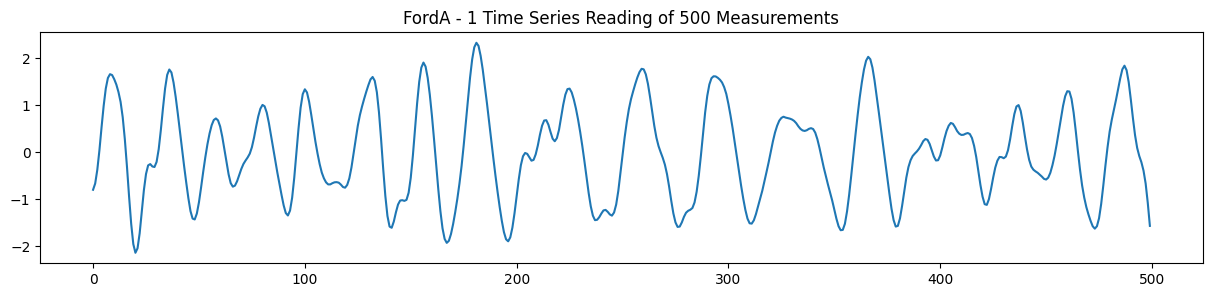

In [3]:
_ = pd.DataFrame(x_train[0]).plot(figsize=(15, 3), title="FordA - 1 Time Series Reading of 500 Measurements", legend=False)

<a id='train_classifier'></a>
### Download Pre-Trained Model
Use a pre-trained model from Keras/HuggingFace.

The pre-trained model is from: https://keras.io/examples/timeseries/timeseries_transformer_classification/
The Hugging face model url is: https://huggingface.co/keras-io/timeseries_transformer_classification

In [4]:
model = from_pretrained_keras("keras-io/timeseries_transformer_classification")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 500, 1)      2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 500, 1)      7169        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

As the model inputs are tensor based, we are selecting Tensor_Based_Classification_Model from aix360 to wrap the model. The wrapper manages the input and output shapes between the original model and the explainer.

In [6]:
class_pos = 0 # to select class probability for explanation
binary_model = Tensor_Based_Classification_Model(model, 
                                                 class_pos=class_pos, 
                                                 input_length=input_length, 
                                                 n_features=1)


Model accuracy for selected test samples.

In [7]:
from sklearn.metrics import accuracy_score

test_sample_size = 10
y_pred = binary_model.predict(x_test[0:test_sample_size,...], verbose=0)

print("model accuracy for {} samples: {}.".format(test_sample_size, accuracy_score(y_test[:test_sample_size], y_pred.astype(int))))

model accuracy for 10 samples: 0.9.


<a id='initialize_tslime'></a>
### Initialize TSLimeExplainer

`TSLimeExplainer` requires a model function which is to be explained and input (history) length used for the input model. The explanation is for selected latest window of length `relevant_history`. If `input_length=20` and `relevant_history=10`, explanation is computed for last 10 time points. The default linear model used for explanation is sklearn's LinearRegression. If a different linear interpretable model is to be used, the model can be wrapped with `aix360.algorithms.tslime.surrogate.LinearSurrogateModel` and provided as param `local_interpretable_model`. 

The explainer uses TSPerturber for generating perturbed/simulated time series data to train the linear interpretable model. Available perturbers are "block-bootstrap", "frequency", "moving_average", "shift". 

In [8]:
import functools
from aix360.algorithms.tsutils.tsperturbers import BlockBootstrapPerturber

relevant_history = 100
explainer = TSLimeExplainer(
    model= functools.partial(binary_model.predict_proba, verbose = 0),
    input_length= x_test.shape[1],
    relevant_history=relevant_history,
    perturbers=[
        BlockBootstrapPerturber(window_length=min(10, input_length-1), block_length=20, block_swap=2),
    ],
    n_perturbations=1000,
    random_seed=22,
)


<a id='compute_explanation'></a>
### Compute Explanation

Compute lime weights for a given input timeseries. 

In [9]:
indx = 3
instance = x_test[indx, ...]

ts_instance = tsFrame(instance) # tsFrame instance
ts_instance.index = pd.to_numeric(ts_instance.index)
ts_instance

,X_1
time,
0,1.240282
1,1.331189
2,1.386596
3,1.383220
4,1.305979
...,...
495,-1.146352
496,-1.011328
497,-0.931222


Explanation object `explanation` contains the history weights computed for selected time window (relevant history) and surrogate prediction for this selected time window.

In [10]:
explanation = explainer.explain_instance(ts_instance)

<a id='plot_explanation'></a>
### Plot Explanation

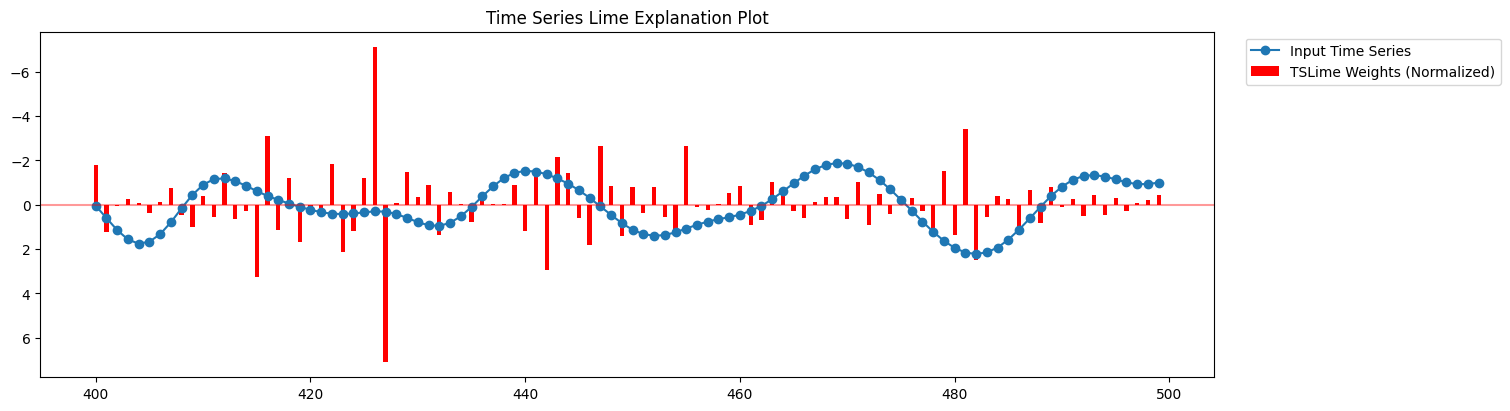

In [11]:
relevant_df = ts_instance[-relevant_history:]

figsize = (15,4)
plt.figure(figsize=figsize, layout='constrained')
plt.plot(relevant_df, label='Input Time Series', marker='o')
plt.gca().invert_yaxis()

normalized_weights = (explanation["history_weights"] / np.mean(np.abs(explanation["history_weights"]))).flatten()

plt.bar(ts_instance.index[-relevant_history:], normalized_weights, 0.4, label = 'TSLime Weights (Normalized)', color='red')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.4)
plt.title("Time Series Lime Explanation Plot")
plt.legend(bbox_to_anchor=(1.25, 1.0), loc='upper right')
plt.show()

The above plot shows the normalized weights for each time point in relevant(selected) history window. Weights are normalized/scaled using mean absolute over all the weights.